### Making training dataset

0. Check out data I am working with pre 0-30cm profile harmonization

1. (not doing) bring on chemical and physical soil variables (*harmonized to 0-30cm per profile via mass preserving spline, mode, and categorical majority*)

2. extract vectors (soil type) per profile/sample site
3. extract rasters (bioclimatic, ecosystem, lithology, landsurface type and DEM/terrain) per profile/sample site
4. merge into one training dataset by profile (or site_id)


In [3]:
# === 1. Imports ===
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load tables from Postgres ===
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)

# === 4. Load usable_sites from GeoPackage (already in UTM 33S) ===
gpkg_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
usable_sites = gpd.read_file(gpkg_path, layer="usable_sites_clean")

print("usable_sites CRS:", usable_sites.crs)
print("usable_sites bounds:", usable_sites.total_bounds)

# --- Keep only relevant columns for merging ---
usable_sites_subset = usable_sites[['profile', 'X_coord', 'Y_coord', 'site_info_id', 'district']].copy()

# --- Filter analyses and morpho by valid profiles ---
valid_profiles = usable_sites_subset['profile'].dropna().unique()
analyses_filtered = analyses[analyses['profile'].isin(valid_profiles)].copy()
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)].copy()

# --- Ensure merge keys are strings ---
analyses_filtered.loc[:, 'sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered.loc[:, 'sample_id'] = morpho_filtered['sample_id'].astype(str)

# --- Merge analyses and morpho ---
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'morpho_id'],
    how='inner',
    suffixes=('', '_morpho')
)

# --- Merge with usable_sites (retain UTM coordinates) ---
merged_final = pd.merge(
    combined_data,
    usable_sites_subset,
    on='profile',
    how='inner'
)

# --- Merge 'year' from samples if present ---
if 'sample_id' in samples.columns and 'year' in samples.columns:
    merged_final = pd.merge(
        merged_final,
        samples[['sample_id', 'year']],
        on='sample_id',
        how='left'
    )

# --- Convert to GeoDataFrame using X/Y coordinates (assume currently in UTM meters from GeoPackage) ---
merged_final_gdf = gpd.GeoDataFrame(
    merged_final,
    geometry=gpd.points_from_xy(merged_final['X_coord'], merged_final['Y_coord']),
    crs="EPSG:32733"  # UTM Zone 33S
)

# convert from degrees to utm
merged_final_gdf = gpd.GeoDataFrame(
    merged_final,
    geometry=gpd.points_from_xy(merged_final['X_coord'], merged_final['Y_coord']),
    crs="EPSG:4326"
).to_crs("EPSG:32733")
merged_final_gdf['X_coord'] = merged_final_gdf.geometry.x
merged_final_gdf['Y_coord'] = merged_final_gdf.geometry.y

# --- Check results ---
print("merged_final_gdf CRS:", merged_final_gdf.crs)
print("merged_final_gdf bounds:", merged_final_gdf.total_bounds)
print("Merged dataset columns:", merged_final_gdf.columns)
print("Number of rows:", merged_final_gdf.shape[0])


usable_sites CRS: EPSG:32733
usable_sites bounds: [ 174544.65507126 7998325.21414117 1482544.10707881 9508186.76580929]
merged_final_gdf CRS: EPSG:32733
merged_final_gdf bounds: [ 174544.60741366 7998325.19151826 1482544.14618381 9508186.76347845]
Merged dataset columns: Index(['lab_sample_id', 'analysis_id', 'morpho_id', 'sample_id', 'profile',
       'soil_biology_id', 'eg', 'thick_sand', 'fine_sand', 'silt',
       ...
       'durability', 'friability', 'thick_contents_count',
       'thick_contents_nature', 'X_coord', 'Y_coord', 'site_info_id',
       'district', 'year', 'geometry'],
      dtype='object', length=108)
Number of rows: 6880


/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_2200/959495250.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['5040' '5456' '11011' ... '8546' '8547' '8548']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  analyses_filtered.loc[:, 'sample_id'] = analyses_filtered['sample_id'].astype(str)


In [4]:
print(merged_final_gdf.X_coord.min(), merged_final_gdf.X_coord.max()) 
print(merged_final_gdf.Y_coord.min(), merged_final_gdf.Y_coord.max())

174544.60741365992 1482544.1461838111
7998325.191518262 9508186.763478452


## A look into the data I am working with

In [5]:
merged_final_gdf.info

<bound method DataFrame.info of       lab_sample_id    analysis_id      morpho_id sample_id profile  \
0               458  Bg_113/57_4_1  Bg_113/57_4_1      5040  113_57   
1               894  Bg_253/57_4_1  Bg_253/57_4_1      5456  253_57   
2                 7   B_109/62_1_1   B_109/62_1_1     11011  109_62   
3              1549   Cb_20/59_3_1   Cb_20/59_3_1      7277   20_59   
4              5965   Mj_27/63_3_1   Mj_27/63_3_1     13391   27_63   
...             ...            ...            ...       ...     ...   
6875           7791   UZ_9c/60_2_1   UZ_9c/60_2_1      8544   9C_60   
6876           7792   UZ_9c/60_3_1   UZ_9c/60_3_1      8545   9C_60   
6877           7793   UZ_9c/60_4_1   UZ_9c/60_4_1      8546   9C_60   
6878           7794   UZ_9c/60_5_1   UZ_9c/60_5_1      8547   9C_60   
6879           7795   UZ_9c/60_6_1   UZ_9c/60_6_1      8548   9C_60   

     soil_biology_id    eg  thick_sand  fine_sand  silt  ...  \
0                     59.0        42.9       13.1  

In [6]:
# 1️⃣  Number of distinct IDs
merged_final_gdf['site_info_id'].nunique()

1470

In [7]:
# 1️ Number of distinct IDs
merged_final_gdf['analysis_id'].nunique()

6880

In [6]:
# List of columns to drop
cols_to_drop = [
    'geo_features_id',
    'climate_id',
    'topo_id',
    'soil_type_id',
    'geom',
    'field_sample_code',  
    'depth',
    'al',
    'si',
    'p',
    's',
    'cl',
    'ti',
    'cr',
    'mn',
    'fe',
    'co',
    'ni',
    'cu',
    'zn',
    'arsenic',
    'se',
    'rb',
    'sr',
    'zr',
    'nb',
    'mo',
    'cd',
    'sn',
    'sb',
    'ba',
    'ta',
    'w',
    'pt',
    'au',
    'hg',
    'tl',
    'pb',
    'bi',
    'th',
    'u'
]

# Drop these columns if they exist in the DataFrame
merged_final = merged_final.drop(columns=[col for col in cols_to_drop if col in merged_final.columns])

# Check the remaining columns
list(merged_final.columns)

['lab_sample_id',
 'analysis_id',
 'morpho_id',
 'sample_id',
 'profile',
 'soil_biology_id',
 'eg',
 'thick_sand',
 'fine_sand',
 'silt',
 'clay',
 'eq_hum',
 'atm_1/3',
 'atm_15',
 'caco3',
 'gypsum',
 'free_iron',
 'organic_carbon',
 'total_n',
 'p205',
 'organic_material',
 'ph_h2o',
 'ph_kcl',
 'Ca++',
 'Mg++',
 'Na+',
 'K+',
 'exchangable_bases_sum',
 'cec',
 'v',
 'conductivity',
 'soluble_sodium',
 'Min_<0,002',
 'Min_0,05-0,02',
 'Min_0,2-0,05',
 'Min_2-0,2',
 'porosity',
 'bulk_density',
 'sample_depth',
 'sample_id_morpho',
 'horizon_layer',
 'upper_depth',
 'lower_depth',
 'moisture_degree',
 'root_quantity',
 'root_diameter',
 'texture',
 'structure_type',
 'structure_class',
 'structure_degree',
 'pore_diameter',
 'pore_quantity',
 'pore_shape',
 'dry_color_name',
 'dry_hue',
 'dry_value',
 'dry_chroma',
 'moist_color_name',
 'moist_hue',
 'moist_value',
 'moist_chroma',
 'compaction',
 'durability',
 'friability',
 'thick_contents_count',
 'thick_contents_nature',
 'X_co

In [7]:
# Count unique years per profile
year_counts = merged_final.groupby('profile')['year'].nunique()

# Profiles with more than 1 year
multi_year_profiles = year_counts[year_counts > 1]

print(f"Number of profiles with multiple years: {len(multi_year_profiles)}")
print("Profiles with multiple years:")
print(multi_year_profiles)


Number of profiles with multiple years: 1
Profiles with multiple years:
profile
101A_58    2
Name: year, dtype: int64


Check crs of coordinates:

In [8]:
import geopandas as gpd

# Path to your geopackage
path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"

# Load the geopackage
gdf = gpd.read_file(path)

# Print CRS and extent
print("CRS:", gdf.crs)
print("Bounds:", gdf.total_bounds)  # [xmin, ymin, xmax, ymax]

# Quick interpretation
xmin, ymin, xmax, ymax = gdf.total_bounds
if -180 <= xmin <= 180 and -90 <= ymin <= 90:
    print("→ Coordinates are in degrees (EPSG:4326).")
else:
    print("→ Coordinates are in projected meters (likely UTM).")


/opt/homebrew/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'usable_site_info_epsg32733_clean.gpkg': 'usable_site_info' (default), 'usable_sites_clean'. Specify layer parameter to avoid this warning.
  result = read_func(


CRS: EPSG:32733
Bounds: [ 174544.65507126 7998325.21414117 1482544.10707881 9508186.76580929]
→ Coordinates are in projected meters (likely UTM).


In [14]:
gdf = gpd.read_file(path, layer="usable_sites_clean")
print(gdf.crs)
print(gdf.total_bounds)


EPSG:32733
[ 174544.65507126 7998325.21414117 1482544.10707881 9508186.76580929]


In [10]:
import geopandas as gpd
from shapely.geometry import Point

# Reproject to UTM 33S
gdf_utm33 = gdf.to_crs("EPSG:32733")  # WGS 84 / UTM zone 33S


In [12]:
print(gdf_utm33.X_coord.min(), gdf_utm33.X_coord.max()) 
print(gdf_utm33.Y_coord.min(), gdf_utm33.Y_coord.max())

12.035 23.962458
-17.998255 -4.446332


Not including this data in training set anymore as it would need to be rasterized

In [11]:
## harmonize chem and physical samples to 1 depth (0-30)

import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from collections import Counter

# ------------------------------
# 1) Mass-preserving spline function (robust)
# ------------------------------
def fit_mpspline(depth_top, depth_bottom, values, lam=1.0, target_depths=[0,30]):
    depth_top = np.array(depth_top)
    depth_bottom = np.array(depth_bottom)
    values = np.array(values)
    
    # Remove NaNs
    mask = ~np.isnan(depth_top) & ~np.isnan(depth_bottom) & ~np.isnan(values)
    depth_top = depth_top[mask]
    depth_bottom = depth_bottom[mask]
    values = values[mask]
    
    n = len(values)
    if n == 0:
        return np.nan
    elif n == 1:
        # One horizon → just return the value
        return values[0]
    elif n == 2:
        # Two horizons → thickness-weighted average
        thickness = depth_bottom - depth_top
        return np.average(values, weights=thickness)
    
    # For 3+ horizons → spline
    midpoints = (depth_top + depth_bottom)/2
    sort_idx = np.argsort(midpoints)
    midpoints = midpoints[sort_idx]
    values = values[sort_idx]
    
    # Remove duplicate midpoints
    unique_midpoints, unique_indices = np.unique(midpoints, return_index=True)
    values = values[unique_indices]
    
    # Ensure spline order fits number of points
    k = min(3, len(values)-1)
    if k < 1:
        return np.nan
    
    spline = UnivariateSpline(unique_midpoints, values, s=lam, k=k)
    
    top, bottom = target_depths
    integral = spline.integral(top, bottom)
    return integral / (bottom - top)

# ------------------------------
# 2) Identify variable types
# ------------------------------
drop_cols = [
    'lab_sample_id','analysis_id','morpho_id','sample_id','sample_id_morpho','X_coord','Y_coord','profile',
    'upper_depth','lower_depth','sample_depth'
]

numeric_cols = merged_final.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in drop_cols]

categorical_cols = merged_final.select_dtypes(include=['object','category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in drop_cols]

# ------------------------------
# 3) Create harmonized dataset per profile
# ------------------------------
profiles = merged_final['profile'].unique()
harmonized_list = []

for pid in profiles:
    profile = merged_final[merged_final['profile'] == pid].copy()
    if profile.empty:
        continue
    
    profile_harmonized = {'profile': pid}
    
    # Numeric variables
    for col in numeric_cols:
        if col in ['organic_carbon','total_n','bulk_density']:
            profile_harmonized[col] = fit_mpspline(
                depth_top=profile['upper_depth'],
                depth_bottom=profile['lower_depth'],
                values=profile[col],
                lam=1.0,
                target_depths=[0,30]
            )
        else:
            thickness = profile['lower_depth'] - profile['upper_depth']
            valid_mask = ~profile[col].isna() & ~thickness.isna()
            if valid_mask.sum() > 0:
                profile_harmonized[col] = np.average(
                    profile[col][valid_mask], 
                    weights=thickness[valid_mask]
                )
            else:
                profile_harmonized[col] = np.nan
    
    # Categorical variables → mode
    for col in categorical_cols:
        vals = profile[col].dropna()
        if not vals.empty:
            profile_harmonized[col] = vals.mode().iloc[0]
        else:
            profile_harmonized[col] = np.nan
    
    # Metadata
    meta_cols = ['X_coord','Y_coord','district','year']
    for col in meta_cols:
        if col in profile.columns:
            profile_harmonized[col] = profile[col].iloc[0]
    
    harmonized_list.append(profile_harmonized)

# ------------------------------
# 4) Convert to DataFrame
# ------------------------------
profile_0_30cm = pd.DataFrame(harmonized_list)

print(f"Shape: {profile_0_30cm.shape} (profiles x variables)")


In [163]:
profile_0_30cm.head()

,profile,eg,thick_sand,fine_sand,silt,clay,eq_hum,atm_15,free_iron,organic_carbon,...,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature,site_info_id,district,X_coord,Y_coord
0,113_57,31.933333,46.273684,15.352632,9.594737,28.800000,17.318182,NaN,1.646364,0.784545,...,,,,,,,2400,Benguela,14.624539,-13.315070
1,253_57,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,,Irregularmente pouco compacto e medianamente c...,"Muito firme (com alguns torroes da mesma cor, ...",,Raro,Saibro quartzoso e de gres,2045,Benguela,15.001662,-12.341700
2,109_62,11.200000,12.862500,37.752500,20.930000,28.447500,21.197500,9.4,2.283750,0.451160,...,6.0,Media,,,,,2523,Bie,16.778372,-13.896562
3,20_59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,33,Cabinda,12.553629,-4.762017
4,27_63,NaN,1.000000,45.318261,7.532174,46.117391,NaN,NaN,NaN,NaN,...,6.0,Media a grande,,,,,1060,Malanje,17.135303,-9.595469


Taking out problematic site locations (not georeferenced)

In [1]:
import pandas as pd

# Identify rows where X_coord or Y_coord is NaN or 0.0
mask_problematic = (
    profile_0_30cm['X_coord'].isnull() |
    (profile_0_30cm['X_coord'] == 0.0) |
    profile_0_30cm['Y_coord'].isnull() |
    (profile_0_30cm['Y_coord'] == 0.0)
)

# Drop problematic rows
profile_0_30cm_clean = profile_0_30cm[~mask_problematic].copy()

# Optional: reset index
profile_0_30cm_clean.reset_index(drop=True, inplace=True)

# Report
print(f"Dropped {mask_problematic.sum()} problematic rows.")
print(f"Remaining rows: {len(profile_0_30cm_clean)}")


NameError: name 'profile_0_30cm' is not defined

In [165]:
# save csv
profile_0_30cm_clean.to_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/profile_0_30cm_clean.csv")

In [166]:
## check for outliers
numeric_cols = profile_0_30cm_clean.select_dtypes(include=['float64', 'int64']).columns
profile_0_30cm_clean[numeric_cols].describe()

,eg,thick_sand,fine_sand,silt,clay,eq_hum,atm_15,free_iron,organic_carbon,p205,...,ph_h2o,ph_kcl,cec,soluble_sodium,porosity,bulk_density,horizon_layer,year,X_coord,Y_coord
count,810.000000,1421.000000,1432.000000,1428.000000,1427.000000,1050.000000,474.000000,969.000000,1222.000000,519.000000,...,1343.000000,1201.000000,1228.000000,1209.000000,1470.000000,1469.000000,1470.000000,1258.000000,1470.000000,1470.000000
mean,6.085098,29.107481,36.787043,7.340589,26.248416,12.477576,9.915294,1.607833,0.718595,0.125318,...,5.895590,4.845484,7.585457,0.940503,0.423654,1.139545,3.650023,1960.686804,15.687077,-10.826322
std,9.348117,19.580898,16.658748,7.018562,16.680387,10.399102,6.676489,2.280296,0.641336,0.431893,...,0.974398,0.864960,8.141821,4.928937,0.133892,0.378345,0.866966,3.175157,2.281815,3.059532
min,0.000000,0.123158,0.000000,0.000000,0.000000,-17.445455,-24.909091,0.010000,0.000000,0.010000,...,4.072432,3.500000,-33.628182,-3.542857,0.000000,-3.643750,1.000000,1946.000000,12.035000,-17.998255
25%,1.000000,12.038636,23.693021,2.443800,12.933797,3.128730,4.238039,0.475000,0.336770,0.040000,...,5.226803,4.266993,3.428060,0.000000,0.390097,1.069746,3.000000,1958.000000,14.033020,-12.960744
50%,2.546777,27.752941,35.151536,5.191116,24.185714,11.865909,9.496753,1.045902,0.566277,0.056000,...,5.636842,4.574118,5.386707,0.000000,0.449443,1.215748,3.687228,1961.000000,15.402227,-10.912705
75%,6.265941,44.138000,48.233552,9.741449,37.336546,19.796517,13.950725,2.038446,0.904860,0.080791,...,6.215917,5.156364,9.017181,0.000000,0.490598,1.341986,4.236154,1963.000000,16.864203,-8.882544
max,61.000000,89.694118,88.894118,48.675000,82.800000,56.355882,29.000000,52.366667,7.581768,6.100000,...,9.400000,8.660000,171.124500,64.857143,2.650000,2.591714,6.772358,1967.000000,23.962458,-4.446332


In [167]:
#IQR method
Q1 = profile_0_30cm_clean[numeric_cols].quantile(0.25)
Q3 = profile_0_30cm_clean[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((profile_0_30cm_clean[numeric_cols] < (Q1 - 1.5 * IQR)) | 
            (profile_0_30cm_clean[numeric_cols] > (Q3 + 1.5 * IQR)))


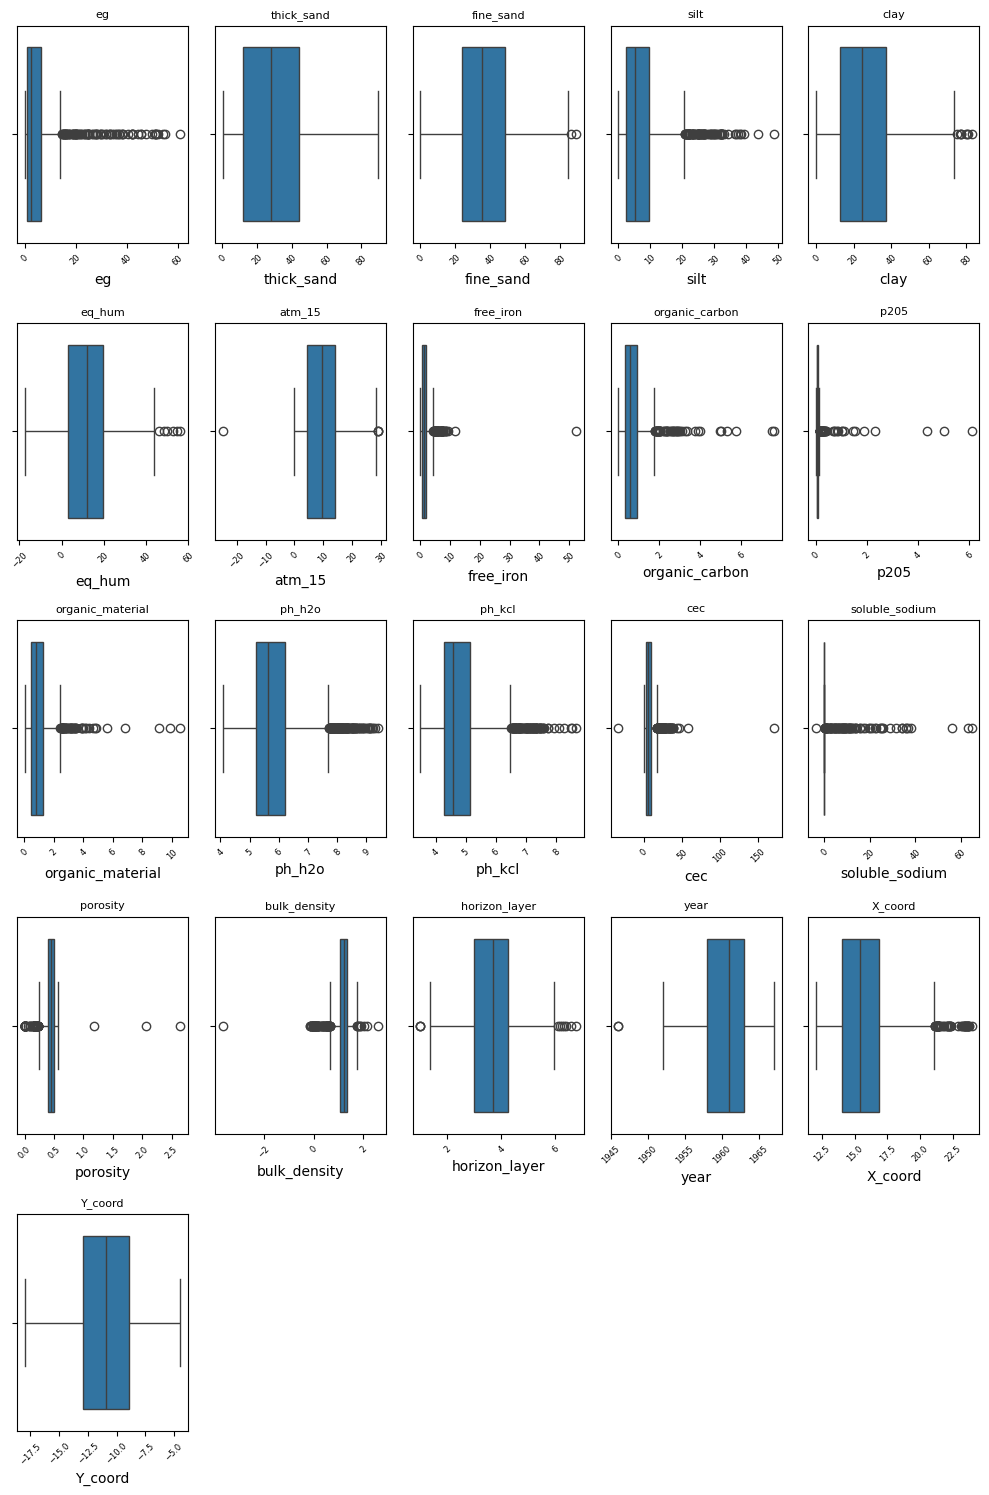

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with multiple subplots
num_vars = len(numeric_cols)
cols_per_row = 5  # number of boxplots per row
rows = (num_vars + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*2, rows*3))
axes = axes.flatten()  # flatten in case of multiple rows

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=profile_0_30cm[col], ax=axes[i])
    axes[i].set_title(col, fontsize=8)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=6)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [169]:
import pandas as pd

# Select only numeric columns
numeric_cols = profile_0_30cm_clean.select_dtypes(include=['float64', 'int64']).columns

# Calculate Q1, Q3 and IQR
Q1 = profile_0_30cm_clean[numeric_cols].quantile(0.25)
Q3 = profile_0_30cm_clean[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Loop through each numeric column and find outliers
outlier_dict = {}

for col in numeric_cols:
    outlier_rows = profile_0_30cm_clean[(profile_0_30cm_clean[col] < (Q1[col] - 1.5 * IQR[col])) |
                                   (profile_0_30cm_clean[col] > (Q3[col] + 1.5 * IQR[col]))]
    if not outlier_rows.empty:
        outlier_dict[col] = outlier_rows.index.tolist()

# Print summary
for col, rows in outlier_dict.items():
    print(f"Column '{col}' has {len(rows)} outlier(s) in rows: {rows}")

# Optional: create a dataframe of all outlier rows
#all_outliers = profile_0_30cm.loc[set(sum(outlier_dict.values(), []))]


Column 'eg' has 87 outlier(s) in rows: [0, 111, 118, 120, 122, 125, 126, 135, 173, 183, 187, 194, 196, 198, 199, 202, 205, 207, 208, 212, 214, 219, 223, 226, 231, 236, 237, 238, 239, 244, 253, 301, 304, 366, 374, 410, 463, 471, 486, 490, 491, 509, 519, 545, 566, 568, 606, 699, 703, 711, 712, 713, 715, 716, 717, 722, 735, 736, 775, 785, 813, 814, 816, 843, 848, 861, 865, 960, 1012, 1053, 1086, 1189, 1280, 1281, 1284, 1285, 1289, 1293, 1299, 1301, 1303, 1310, 1317, 1373, 1418, 1459, 1467]
Column 'fine_sand' has 2 outlier(s) in rows: [873, 1013]
Column 'silt' has 87 outlier(s) in rows: [2, 20, 124, 136, 139, 140, 141, 142, 148, 151, 156, 162, 168, 191, 243, 248, 347, 349, 351, 358, 359, 442, 483, 488, 503, 504, 506, 507, 512, 513, 521, 523, 531, 532, 551, 553, 567, 570, 579, 590, 595, 603, 655, 807, 839, 843, 909, 978, 988, 1017, 1033, 1037, 1060, 1129, 1140, 1144, 1151, 1155, 1157, 1164, 1168, 1173, 1176, 1185, 1191, 1192, 1197, 1200, 1203, 1204, 1208, 1209, 1212, 1215, 1264, 1317, 1319,

In [11]:
## remove nulls from usable_site_info

import geopandas as gpd
import pandas as pd

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
points = gpd.read_file(points_path)

# View the first few rows
points.head()

import pandas as pd

# Identify rows where X_coord or Y_coord is NaN or 0.0
mask_problematic = (
    points['X_coord'].isnull() |
    (points['X_coord'] == 0.0) |
    points['Y_coord'].isnull() |
    (points['Y_coord'] == 0.0)
)

# Drop problematic rows
points_clean = points[~mask_problematic].copy()

# Optional: reset index
points_clean.reset_index(drop=True, inplace=True)

# Report
print(f"Dropped {mask_problematic.sum()} problematic rows.")
print(f"Remaining rows: {len(points_clean)}")

# Save cleaned GeoPackage
output_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points_clean.to_file(output_path, layer="usable_sites_clean", driver="GPKG")


Dropped 14 problematic rows.
Remaining rows: 1474


## Extract soil data and lithology from .tif to csv per profile

In [207]:
import geopandas as gpd
import pandas as pd
import os
import re  # for regex

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
soil_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/angola_soil_gpkg_stuff/angola_soil_data2.gpkg"
# lithology_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/lithology2.gpkg"


# --- Load data ---
points = gpd.read_file(
    points_path,
    layer="usable_sites_clean"   # 👈 specify the layer you actually want
)
soil = gpd.read_file(soil_path)[["faosoil_id", "geometry"]]
#lithology = gpd.read_file(lithology_path)[["africa_lithology_90m.img.vat_lithology", "geometry"]]

# --- Ensure CRS matches ---
if points.crs != soil.crs:
    soil = soil.to_crs(points.crs)
# if points.crs != lithology.crs:
#     lithology = lithology.to_crs(points.crs)

# --- Spatial join ---
points_soil = gpd.sjoin(points, soil, how="left", predicate="intersects")

# Drop index_right from first join
if "index_right" in points_soil.columns:
    points_soil = points_soil.drop(columns=["index_right"])

#points_soil_lith = gpd.sjoin(points_soil, lithology, how="left", predicate="intersects")

# Drop index_right from second join
if "index_right" in points_soil.columns:
    points_soil = points_soil.drop(columns=["index_right"])

# --- Remove numbers from lithology column ---
# # Example: "1. Carbonate" → "Carbonate"
# points_soil_lith["africa_lithology_90m.img.vat_lithology"] = points_soil_lith[
#     "africa_lithology_90m.img.vat_lithology"
# ].apply(lambda x: re.sub(r"^\d+\.\s*", "", str(x)))

# Drop multiple columns
points_soil_clean = points_soil
points_soil_clean = points_soil_clean.drop(columns=["geo_features_id", "climate_id", "topo_id", "soil_type_id"])
points_soil_clean = points_soil_clean.drop(columns=["geometry"])

# --- Save clean CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_from_vector_clean.csv"
points_soil_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)

✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_from_vector_clean.csv


In [172]:
points_soil_clean.columns

Index(['site_info_id', 'profile', 'X_coord', 'Y_coord', 'district',
       'faosoil_id'],
      dtype='object')

In [209]:
# Count unique profiles
n_profiles1 = points_soil_clean['profile'].nunique()
print(f"Unique profiles: {n_profiles1}")

Unique profiles: 1474


In [208]:
points_soil_clean.head(2)

,site_info_id,profile,X_coord,Y_coord,district,faosoil_id
0,2770,1_57,12.161278,-15.222598,Namibe,131.0
1,48,1_59,12.575774,-4.866985,Cabinda,112.0


## Extract the landsurfaceforms raster values per profile

In [210]:
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# --- Use merged_final_gdf directly ---
points = merged_final_gdf.copy()

# --- Create geometry from X_coord / Y_coord if not already present ---
if points.geometry.is_empty.all() or points.geometry.isnull().all():
    points = gpd.GeoDataFrame(
        points,
        geometry=gpd.points_from_xy(points['X_coord'], points['Y_coord']),
        crs=points.crs
    )

# --- Load your raster ---
raster_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/covariates_rasters/landsurfaceforms_1km.tif"
raster = rasterio.open(raster_path)

# --- Ensure points are in the same CRS as the raster ---
if points.crs != raster.crs:
    points = points.to_crs(raster.crs)

# --- Extract raster values at point locations ---
coords = [(x, y) for x, y in zip(points.geometry.x, points.geometry.y)]
points['landsurface_value'] = [val[0] for val in raster.sample(coords)]

# --- Optional: convert codes to descriptive categories ---
landsurface_lookup = {
    1: "smooth_plains",
    2: "irregular_plains",
    3: "escarpments",
    4: "hills",
    5: "breaks",
    6: "low_mountains",
    7: "high_mountains/deep_canyons"
}
points['landsurface_label'] = points['landsurface_value'].map(landsurface_lookup)

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id"]
landsurface_points_clean = points.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/landsurface_sample_points.csv"
landsurface_points_clean.drop(columns='geometry').to_csv(output_csv, index=False)

print("CSV saved at:", output_csv)


CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/landsurface_sample_points.csv


In [211]:
print(f"Shape: {landsurface_points_clean.shape} (profiles x variables)")
landsurface_points_clean.head()

Shape: (6880, 110) (profiles x variables)


,lab_sample_id,analysis_id,morpho_id,sample_id,profile,soil_biology_id,eg,thick_sand,fine_sand,silt,...,thick_contents_count,thick_contents_nature,X_coord,Y_coord,site_info_id,district,year,geometry,landsurface_value,landsurface_label
0,458,Bg_113/57_4_1,Bg_113/57_4_1,5040,113_57,,59.0,42.9,13.1,10.9,...,,,459336.209497,8.527991e+06,2400,Benguela,1957.0,POINT (459336.209 8527990.763),2,irregular_plains
1,894,Bg_253/57_4_1,Bg_253/57_4_1,5456,253_57,,NaN,NaN,0.0,0.0,...,Raro,Saibro quartzoso e de gres,500180.692732,8.635661e+06,2045,Benguela,1957.0,POINT (500180.693 8635661.383),6,low_mountains
2,7,B_109/62_1_1,B_109/62_1_1,11011,109_62,,1.0,15.3,48.5,17.6,...,,,692160.845254,8.462997e+06,2523,Bie,1962.0,POINT (692160.845 8462996.974),2,irregular_plains
3,1549,Cb_20/59_3_1,Cb_20/59_3_1,7277,20_59,,NaN,NaN,NaN,NaN,...,,,228631.694806,9.473161e+06,33,Cabinda,1959.0,POINT (228631.695 9473160.686),2,irregular_plains
4,5965,Mj_27/63_3_1,Mj_27/63_3_1,13391,27_63,,NaN,NaN,NaN,NaN,...,,,734354.850480,8.938585e+06,1060,Malanje,1963.0,POINT (734354.85 8938585.159),1,smooth_plains


In [213]:
landsurface_points_clean.columns

Index(['lab_sample_id', 'analysis_id', 'morpho_id', 'sample_id', 'profile',
       'soil_biology_id', 'eg', 'thick_sand', 'fine_sand', 'silt',
       ...
       'thick_contents_count', 'thick_contents_nature', 'X_coord', 'Y_coord',
       'site_info_id', 'district', 'year', 'geometry', 'landsurface_value',
       'landsurface_label'],
      dtype='object', length=110)

## Extract lithology value

In [177]:
import rasterio
import geopandas as gpd
import pandas as pd

# --- Load your points ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points = gpd.read_file(
    points_path,
    layer="usable_sites_clean"   # 
)

# --- Load your raster ---
litho_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/covariates_rasters/lithology_1km.tif"
raster = rasterio.open(litho_path)

# --- Ensure points are in the same CRS as the raster ---
if points.crs != raster.crs:
    points = points.to_crs(raster.crs)

# --- Extract raster values at point locations ---
coords = [(x, y) for x, y in zip(points.geometry.x, points.geometry.y)]
points['litho_value'] = [val[0] for val in raster.sample(coords)]

# --- Optional: convert codes to descriptive categories ---
litho_lookup = {
    1: "Carbonate",
    2: "Karst",
    3: "Non-Carbonate",
    4: "Metasedimentary",
    5: "Alkaline Intrusive Volcanic",
    6: "Silicic",
    7: "Metaigneous"
}
points['litho_label'] = points['litho_value'].map(litho_lookup)

# --- Define your working DataFrame ---
litho_points = points.copy()

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id"]
litho_points_clean = litho_points.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/litho_sample_points.csv"
litho_points_clean.drop(columns='geometry').to_csv(output_csv, index=False)

print("CSV saved at:", output_csv)


CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/litho_sample_points.csv


In [178]:
print(f"Shape: {litho_points_clean.shape} (profiles x variables)")
litho_points_clean.head()

Shape: (1474, 8) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,geometry,litho_value,litho_label
0,2770,1_57,12.161278,-15.222598,Namibe,POINT (195025.855 8315068.542),1,Carbonate
1,48,1_59,12.575774,-4.866985,Cabinda,POINT (231130.92 9461556.108),5,Alkaline Intrusive Volcanic
2,881,1_63,17.081955,-9.274587,Malanje,POINT (728708.838 8974120.144),2,Karst
3,2675,10_54,14.445188,-14.922688,Huila,POINT (440331.329 8350150.683),1,Carbonate
4,2698,10_55,13.455059,-14.977228,Huila,POINT (333872.184 8343613.735),2,Karst


## extract the ecosystem raster values per profile

In [179]:
import rasterio
import geopandas as gpd

# --- Load point layer (GeoPackage, choose correct layer if needed) ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points = gpd.read_file(
    points_path,
    layer="usable_sites_clean"   
)

# --- Load raster (ecosystem.tif) ---
raster_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/covariates_rasters/labelled_ecosystems32733_1km.tif"
with rasterio.open(raster_path) as raster:
    # Match CRS
    if points.crs != raster.crs:
        points = points.to_crs(raster.crs)

    # Extract **band-1** values at each point location
    coords = [(geom.x, geom.y) for geom in points.geometry]
    points["formation"] = [val[0] for val in raster.sample(coords)]

# --- Define your working DataFrame ---
points = points.copy()

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id"]
points_clean = points.drop(columns=drop_cols, errors="ignore")


# --- Save or use the results ---
out_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecoformation_sample_points.csv"
points_clean.drop(columns="geometry").to_csv(out_csv, index=False)

print(f"Eco Formation values extracted and saved to: {out_csv}")


Eco Formation values extracted and saved to: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecoformation_sample_points.csv


In [180]:
print(f"Shape: {points_clean.shape} (profiles x variables)")
points_clean.head()

Shape: (1474, 7) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,geometry,formation
0,2770,1_57,12.161278,-15.222598,Namibe,POINT (195025.855 8315068.542),204
1,48,1_59,12.575774,-4.866985,Cabinda,POINT (231130.92 9461556.108),1
2,881,1_63,17.081955,-9.274587,Malanje,POINT (728708.838 8974120.144),113
3,2675,10_54,14.445188,-14.922688,Huila,POINT (440331.329 8350150.683),113
4,2698,10_55,13.455059,-14.977228,Huila,POINT (333872.184 8343613.735),113


## bioclimatic rasters to csv for each sample point

In [181]:
#### bioclimatic rasters to CSV for each sample point

import rasterio
import geopandas as gpd
import pandas as pd
import glob
import os
import numpy as np

# --- Load point layer (GeoPackage, choose correct layer if needed) ---
# --- Load your points ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points = gpd.read_file(
    points_path,
    layer="usable_sites_clean"   # 
)

bioclimraster_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/covariates_rasters/bioclimatic32733_cleaned/"

# --- Load point data ---
bioclim_perpoint = gpd.read_file(points_path)

# --- Get list of rasters (assuming .tif files) ---
bioclimraster_files = sorted(glob.glob(os.path.join(bioclimraster_folder, "*.tif")))

# --- Reproject points once (using first raster as reference) ---
if bioclimraster_files:
    with rasterio.open(bioclimraster_files[0]) as src_ref:
        if bioclim_perpoint.crs != src_ref.crs:
            bioclim_perpoint = bioclim_perpoint.to_crs(src_ref.crs)

# --- Extract raster values for each point ---
coords = [(x, y) for x, y in zip(bioclim_perpoint.geometry.x, bioclim_perpoint.geometry.y)]

for raster_path in bioclimraster_files:
    name = os.path.splitext(os.path.basename(raster_path))[0]  # e.g. bio1.tif → "bio1"
    with rasterio.open(raster_path) as src:
        values = []
        for val in src.sample(coords):
            # Handle NoData / masked values
            if val is None or np.isnan(val[0]):
                values.append(np.nan)
            else:
                values.append(val[0])
        bioclim_perpoint[name] = values

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry"]
bioclim_perpoint_clean = bioclim_perpoint.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv"
bioclim_perpoint_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)


/opt/homebrew/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'usable_site_info_epsg32733_clean.gpkg': 'usable_site_info' (default), 'usable_sites_clean'. Specify layer parameter to avoid this warning.
  result = read_func(


✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv


In [182]:
print(f"Shape: {bioclim_perpoint_clean.shape} (profiles x variables)")
bioclim_perpoint_clean.head()

Shape: (1474, 24) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,2mean_temp_coldest_quarter32733,annual_mean_temp,annual_precip2,isothermality_32733,max_temp_warmest_month32733,...,min_temp_coldest_month32733,precip_coldest_quarter32733,precip_driest_month32733,precip_driest_quarter32733,precip_seasonality2,precip_warmest_quarter32733,precip_wettest_month32733,precip_wettest_quarter32733,temp_annual_range32733,temp_seasonality32733
0,2770,1_57,12.161278,-15.222598,Namibe,17.299999,20.692232,76,51.184036,28.283258,...,12.9,1,0,0,101,47,24,50,15.400000,25.000542
1,48,1_59,12.575774,-4.866985,Cabinda,22.299999,25.188669,1143,54.972408,31.293846,...,17.9,3,0,3,79,525,196,525,13.382994,18.245573
2,881,1_63,17.081955,-9.274587,Malanje,21.200001,21.685974,1369,72.330200,30.931761,...,11.1,9,0,9,75,542,227,588,19.820923,4.635531
3,2675,10_54,14.445188,-14.922688,Huila,15.900000,20.039265,895,58.460194,30.497786,...,6.7,2,0,1,98,303,227,509,23.780096,27.048286
4,2698,10_55,13.455059,-14.977228,Huila,15.100000,17.571049,815,66.047607,27.182159,...,6.8,9,0,0,90,163,177,438,20.374357,17.226534


## terrain / DEM features to csv for each sample point

In [183]:
## terrain / DEM features to csv for each sample point

import rasterio
import geopandas as gpd
import pandas as pd
import glob
import os
import numpy as np

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points = gpd.read_file(
    points_path,
    layer="usable_sites_clean"   
)

terrain_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/covariates_rasters/dem_1km/"

# --- Load point data ---
DEM_perpoint = gpd.read_file(points_path)

# --- Get list of rasters (assuming .tif files) ---
terrain_files = sorted(glob.glob(os.path.join(terrain_folder, "*.tif")))

# --- Reproject points once (using first raster as reference) ---
if terrain_files:
    with rasterio.open(terrain_files[0]) as src_ref:
        if DEM_perpoint.crs != src_ref.crs:
            DEM_perpoint = DEM_perpoint.to_crs(src_ref.crs)

# --- Extract raster values for each point ---
coords = [(x, y) for x, y in zip(DEM_perpoint.geometry.x, DEM_perpoint.geometry.y)]

for raster_path in terrain_files:
    name = os.path.splitext(os.path.basename(raster_path))[0]  # e.g. slope.tif → "slope"
    with rasterio.open(raster_path) as src:
        values = []
        for val in src.sample(coords):
            if val is None or np.isnan(val[0]):
                values.append(np.nan)
            else:
                values.append(val[0])
        DEM_perpoint[name] = values
    print(f"✅ Extracted {name}")

# --- Add categorical labels for aspect_classes ---
if "aspect_classes" in DEM_perpoint.columns:
    aspect_lookup = {
        1: "N", 2: "NE", 3: "E", 4: "SE",
        5: "S", 6: "SW", 7: "W", 8: "NW"
    }
    DEM_perpoint["aspect_label"] = DEM_perpoint["aspect_classes"].map(aspect_lookup)

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry"]
DEM_perpoint_clean = DEM_perpoint.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv"
DEM_perpoint_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)

/opt/homebrew/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'usable_site_info_epsg32733_clean.gpkg': 'usable_site_info' (default), 'usable_sites_clean'. Specify layer parameter to avoid this warning.
  result = read_func(


✅ Extracted MRVBF_1km
✅ Extracted RLD_1km
✅ Extracted aspect_1km
✅ Extracted aspect_cos_1km
✅ Extracted aspect_sin_1km
✅ Extracted dem_filledfiltered_1km
✅ Extracted flow_accumulation_1km
✅ Extracted relief_1km
✅ Extracted ridge_levels_1km
✅ Extracted roughness_1km
✅ Extracted slope_1km
✅ Extracted twi_300m_1km
✅ Extracted valleydepth2_1km
✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv


In [184]:
print(f"Shape: {DEM_perpoint_clean.shape} (profiles x variables)")
DEM_perpoint_clean.head()

Shape: (1474, 18) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,MRVBF_1km,RLD_1km,aspect_1km,aspect_cos_1km,aspect_sin_1km,dem_filledfiltered_1km,flow_accumulation_1km,relief_1km,ridge_levels_1km,roughness_1km,slope_1km,twi_300m_1km,valleydepth2_1km
0,2770,1_57,12.161278,-15.222598,Namibe,3.154941,56.441212,193.738007,0.002505,-0.099684,52.872677,2.872340e+06,12.343295,474.526031,12.343295,2.296439,24.104668,421.653351
1,48,1_59,12.575774,-4.866985,Cabinda,1.309310,87.681091,167.892792,-0.005290,0.026958,115.344627,2.679640e+05,51.778843,587.699402,51.778843,9.156327,20.323660,472.354767
2,881,1_63,17.081955,-9.274587,Malanje,-0.007585,226.943008,152.635284,0.142316,0.283865,1178.080688,1.370977e+05,77.656128,1201.512817,77.656128,5.827072,19.555119,23.432125
3,2675,10_54,14.445188,-14.922688,Huila,4.801522,56.136410,159.756821,0.223389,0.161232,1310.244751,2.318215e+06,19.633915,1425.943848,19.633915,1.488632,22.817108,115.699120
4,2698,10_55,13.455059,-14.977228,Huila,1.245921,71.276505,188.588089,-0.412049,-0.074023,2021.696533,8.318778e+05,19.224989,2084.452148,19.224989,4.728902,21.555494,62.755573


## Joining all files for training data table

In [185]:
# join all files for training data table BY site_info_id

# DEM_perpoint_clean
# bioclim_perpoint_clean
# landsurface_points_clean
# ecosystems_points_clean
# points_soil_lith_clean
# profile_0_30cm (info about soil phys and chem properties) NO LONGER USING


In [186]:
import pandas as pd
from functools import reduce
import geopandas as gpd

# --- Load all CSVs ---
DEM_perpoint_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv")
bioclim_perpoint_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv")
landsurface_points_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/landsurface_sample_points.csv")
ecosystems_points_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecoformation_sample_points.csv")
points_soil_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_from_vector_clean.csv")
points_litho_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/litho_sample_points.csv")

#profile_0_30cm_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/profile_0_30cm_clean.csv")

# --- Load reference GeoDataFrame for shared columns ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points = gpd.read_file(
    points_path,
    layer="usable_sites_clean"   # 
)

reference_cols = points_clean[['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district']].copy()

# --- Ensure site_info_id is string in reference ---
reference_cols['site_info_id'] = reference_cols['site_info_id'].astype(str)

# --- List of dataframes to merge, drop shared columns to avoid duplicates ---
dfs = []
for df in [
    DEM_perpoint_clean,
    bioclim_perpoint_clean,
    landsurface_points_clean,
    ecosystems_points_clean,
    points_soil_clean,
    points_litho_clean
    #profile_0_30cm_clean
]:
    df_copy = df.copy()
    # Drop columns that will be added back from reference
    df_copy = df_copy.drop(columns=['X_coord','Y_coord','profile','district'], errors='ignore')
    # Ensure site_info_id is string for merging
    df_copy['site_info_id'] = df_copy['site_info_id'].astype(str)
    dfs.append(df_copy)

# --- Inner merge all tables on site_info_id ---
train_df = reduce(lambda left, right: pd.merge(left, right, on='site_info_id', how='inner'), dfs)

# --- Merge back the shared columns ---
train_df_final = pd.merge(reference_cols, train_df, on='site_info_id', how='inner')

# --- Save the final training table ---
output_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/training_data_table_final.csv"
train_df_final.to_csv(output_path, index=False)

print(f"Training table created: {train_df_final.shape[0]} rows, {train_df_final.shape[1]} columns")


Training table created: 1474 rows, 43 columns


In [187]:
train_df_final.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district',
       'MRVBF_1km', 'RLD_1km', 'aspect_1km', 'aspect_cos_1km',
       'aspect_sin_1km', 'dem_filledfiltered_1km', 'flow_accumulation_1km',
       'relief_1km', 'ridge_levels_1km', 'roughness_1km', 'slope_1km',
       'twi_300m_1km', 'valleydepth2_1km', '2mean_temp_coldest_quarter32733',
       'annual_mean_temp', 'annual_precip2', 'isothermality_32733',
       'max_temp_warmest_month32733', 'mean_temp_coldest_quarter32733',
       'mean_temp_driest_quarter32733', 'mean_temp_warmest_quarter32733',
       'mean_temp_wettest_quarter32733', 'min_temp_coldest_month32733',
       'precip_coldest_quarter32733', 'precip_driest_month32733',
       'precip_driest_quarter32733', 'precip_seasonality2',
       'precip_warmest_quarter32733', 'precip_wettest_month32733',
       'precip_wettest_quarter32733', 'temp_annual_range32733',
       'temp_seasonality32733', 'landsurface_value', 'landsurface_label',
       'formation', 'faosoi

ADD HARMONIZED SOC STOCK TO TRAINING DATA SET

In [188]:
import pandas as pd

# Load SOC stock CSV
soc_stock = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/harmonized_soc_with_log.csv")

# Keep only profile and log_soc_stock, drop other columns
soc_stock_clean = soc_stock[['profile', 'log_soc_stock']]

# Load your training dataset
train_df_final = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/training_data_table_final.csv")

# Merge training dataset with SOC stock by profile
train_with_soc = pd.merge(train_df_final, soc_stock_clean, on='profile', how='inner')

# Optional: save the merged dataset to CSV
train_with_soc.to_csv("/Users/inesschwartz/Desktop/training_data_with_log_soc.csv", index=False)

print("Merged training dataset created with log-transformed SOC stock as response variable.")
train_with_soc.head()


Merged training dataset created with log-transformed SOC stock as response variable.


,site_info_id,X_coord,Y_coord,profile,district,MRVBF_1km,RLD_1km,aspect_1km,aspect_cos_1km,aspect_sin_1km,...,precip_wettest_quarter32733,temp_annual_range32733,temp_seasonality32733,landsurface_value,landsurface_label,formation,faosoil_id,litho_value,litho_label,log_soc_stock
0,2770,12.161278,-15.222598,1_57,Namibe,3.154941,56.441210,193.73800,0.002505,-0.099684,...,50,15.400000,25.000542,1,smooth_plains,204,131.0,1,Carbonate,0.123792
1,48,12.575774,-4.866985,1_59,Cabinda,1.309310,87.681090,167.89279,-0.005290,0.026958,...,525,13.382994,18.245573,5,breaks,1,112.0,5,Alkaline Intrusive Volcanic,1.344501
2,881,17.081955,-9.274587,1_63,Malanje,-0.007585,226.943010,152.63528,0.142316,0.283865,...,588,19.820923,4.635531,2,irregular_plains,113,62.0,2,Karst,1.309453
3,2698,13.455059,-14.977228,10_55,Huila,1.245921,71.276505,188.58809,-0.412049,-0.074023,...,438,20.374357,17.226534,2,irregular_plains,113,62.0,2,Karst,1.263857
4,2139,16.269295,-12.580465,100_56,Huambo,3.043891,95.820830,188.93633,0.271031,-0.047712,...,654,21.457123,15.427565,2,irregular_plains,97,43.0,2,Karst,1.260593


In [189]:
train_with_soc.to_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/training_data_table_final.csv", index=False)


In [190]:
train_with_soc.to_csv("/Users/inesschwartz/Desktop/training_data.csv", index=False)


In [191]:
train_with_soc.shape  # number of rows and columns

train_with_soc.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district',
       'MRVBF_1km', 'RLD_1km', 'aspect_1km', 'aspect_cos_1km',
       'aspect_sin_1km', 'dem_filledfiltered_1km', 'flow_accumulation_1km',
       'relief_1km', 'ridge_levels_1km', 'roughness_1km', 'slope_1km',
       'twi_300m_1km', 'valleydepth2_1km', '2mean_temp_coldest_quarter32733',
       'annual_mean_temp', 'annual_precip2', 'isothermality_32733',
       'max_temp_warmest_month32733', 'mean_temp_coldest_quarter32733',
       'mean_temp_driest_quarter32733', 'mean_temp_warmest_quarter32733',
       'mean_temp_wettest_quarter32733', 'min_temp_coldest_month32733',
       'precip_coldest_quarter32733', 'precip_driest_month32733',
       'precip_driest_quarter32733', 'precip_seasonality2',
       'precip_warmest_quarter32733', 'precip_wettest_month32733',
       'precip_wettest_quarter32733', 'temp_annual_range32733',
       'temp_seasonality32733', 'landsurface_value', 'landsurface_label',
       'formation', 'faosoi

Adjust column names

In [192]:
columns_renamed = {
    "aspect_1km": "aspect",
    "aspect_cos_1km": "aspect_cos",
    "aspect_sin_1km": "aspect_sin",
    "MRVBF_1km": "MRVBF",
    "RLD_1km": "RLD",
    "dem_filledfiltered_1km": "DEM",
    "flow_accumulation_1km": "flow_accumulation",
    "relief_1km": "relief",
    "ridge_levels_1km": "ridge_levels",
    "roughness_1km": "roughness",  # corrected key
    "slope_1km": "slope",
    "twi_300m_1km": "TWI",
    "valleydepth2_1km": "valleydepth",

    "2mean_temp_coldest_quarter32733": "mean_temp_coldest_quarter",
    "annual_precip2": "annual_precip",
    "isothermality_32733": "isothermality",
    "max_temp_warmest_month32733": "max_temp_warmest_month",
    # duplicate dropped: "mean_temp_coldest_quarter32733"
    "mean_temp_driest_quarter32733": "mean_temp_driest_quarter",
    "mean_temp_warmest_quarter32733": "mean_temp_warmest_quarter",
    "mean_temp_wettest_quarter32733": "mean_temp_wettest_quarter",
    "min_temp_coldest_month32733": "min_temp_coldest_month",
    "precip_coldest_quarter32733": "precip_coldest_quarter",
    "precip_driest_month32733": "precip_driest_month",
    "precip_warmest_quarter32733": "precip_warmest_quarter",
    "precip_driest_quarter32733": "precip_driest_quarter",
    "precip_wettest_month32733": "precip_wettest_month",
    "precip_seasonality2": "precip_seasonality",
    "temp_annual_range32733": "temp_annual_range",
    "temp_seasonality32733": "temp_seasonality",
    "precip_wettest_quarter32733": "precip_wettest_quarter"
}

columns_to_drop = [
    "mean_temp_coldest_quarter32733",  # duplicate column
    "landsurface_label",
    "litho_label",
]

# Rename + drop
train_with_soc = (
    train_with_soc
        .rename(columns=columns_renamed)
        .drop(columns=columns_to_drop, errors="ignore")
)

# Save to CSV
output_path = "/Users/inesschwartz/Desktop/training_data.csv"
train_with_soc.to_csv(output_path, index=False)

print(f"Cleaned DataFrame saved to: {output_path}")


Cleaned DataFrame saved to: /Users/inesschwartz/Desktop/training_data.csv


In [193]:
print(train_with_soc.X_coord.min(), train_with_soc.X_coord.max()) 
print(train_with_soc.Y_coord.min(), train_with_soc.Y_coord.max())

12.035 23.962458
-17.998255 -4.446332
